# Bayesian estimation of the bivariate beta parameter

In [1]:
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path
import abcpy
from scipy import stats

import matplotlib.pyplot as plt
import arviz as az
import os
import tqdm

import sys
sys.path.append('../scripts')
    
from parameter_estimation import BivariateBeta as bb_class

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [4]:
stanfile1 = os.path.join('..', 'scripts', 'bivariate-beta-model.stan')
model_v1 = CmdStanModel(stan_file=stanfile1, cpp_options={'STAN_THREADS':'true'})

stanfile2 = os.path.join('..', 'scripts', 'bivariate-beta-model-v2.stan')
model_v2 = CmdStanModel(stan_file=stanfile2, cpp_options={'STAN_THREADS':'true'})

stanfile3 = os.path.join('..', 'scripts', 'bivariate-beta-model-v3.stan')
model_v3 = CmdStanModel(stan_file=stanfile3, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


## Quick verifications

Generating the data

In [4]:
true_alpha = np.array([2,7,3,1])
n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

# Gamma hyperparameters
a = np.array([1,1,1,1])
b = 0.1*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

## Model V1

In [5]:
model_fit_v1 = model_v1.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [6]:
print(model_fit_v1.diagnose())

Processing csv files: /tmp/tmppiiymw5r/bivariate-beta-model-20220621163017_1.csv, /tmp/tmppiiymw5r/bivariate-beta-model-20220621163017_2.csv, /tmp/tmppiiymw5r/bivariate-beta-model-20220621163017_3.csv, /tmp/tmppiiymw5r/bivariate-beta-model-20220621163017_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
df = model_fit_v1.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],2.3,0.017,0.60,1.50,2.3,3.4,1288.0,1.1,1.0
alpha[2],7.8,0.030,1.20,5.90,7.7,9.7,1518.0,1.3,1.0
alpha[3],3.3,0.014,0.55,2.40,3.2,4.2,1610.0,1.4,1.0
alpha[4],1.4,0.013,0.48,0.69,1.3,2.2,1408.0,1.2,1.0


In [8]:
inf_data = az.from_cmdstanpy(model_fit_v1)

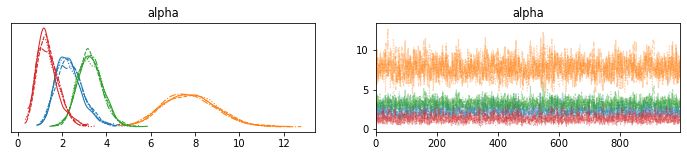

In [9]:
az.plot_trace(inf_data)
plt.show()

## Model V2

In [5]:
model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [6]:
print(model_fit_v2.diagnose())

Processing csv files: /tmp/tmpwafzw_1q/bivariate-beta-model-v2-20220623190752_1.csv, /tmp/tmpwafzw_1q/bivariate-beta-model-v2-20220623190752_2.csv, /tmp/tmpwafzw_1q/bivariate-beta-model-v2-20220623190752_3.csv, /tmp/tmpwafzw_1q/bivariate-beta-model-v2-20220623190752_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
df = model_fit_v2.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.8,0.022,0.44,1.10,1.70,2.6,405.0,198.0,1.0
alpha[2],7.0,0.030,1.10,5.40,7.00,8.8,1209.0,590.0,1.0
alpha[3],3.0,0.010,0.48,2.30,3.00,3.8,2104.0,1027.0,1.0
alpha[4],1.0,0.019,0.36,0.54,0.98,1.7,346.0,169.0,1.0


## Model V3 

Let it to be faster! I couldn't yet, unhappily...

In [8]:
model_fit_v3 = model_v3.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=1000, adapt_delta=0.8)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [9]:
print(model_fit_v3.diagnose())

Processing csv files: /tmp/tmpwafzw_1q/bivariate-beta-model-v3-20220623190757_1.csv, /tmp/tmpwafzw_1q/bivariate-beta-model-v3-20220623190757_2.csv, /tmp/tmpwafzw_1q/bivariate-beta-model-v3-20220623190757_3.csv, /tmp/tmpwafzw_1q/bivariate-beta-model-v3-20220623190757_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [10]:
df = model_fit_v3.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.8,0.021,0.43,1.20,1.8,2.6,416.0,167.0,1.0
alpha[2],7.1,0.028,1.10,5.40,7.0,8.9,1437.0,577.0,1.0
alpha[3],3.0,0.010,0.48,2.30,3.0,3.9,2148.0,863.0,1.0
alpha[4],1.1,0.018,0.34,0.56,1.0,1.7,357.0,143.0,1.0


## Comparing v1 and v2

They should provide similar estimates for the same data.

In [16]:
comparing = ['Mean', '5%', '50%', '95%']
diff = abs(model_fit_v1.summary()[comparing].iloc[1:5] - model_fit_v2.summary()[comparing].iloc[1:5])
diff = diff/model_fit_v1.summary()[comparing].iloc[1:5]
# the percentage error is
diff

,Mean,5%,50%,95%
name,,,,
alpha[1],0.043478,0.000000,0.00000,0.000000
alpha[2],0.000000,0.016949,0.00000,0.010309
alpha[3],0.000000,0.000000,0.03125,0.000000
alpha[4],0.000000,0.057971,0.00000,0.045455


## Simulated-based calibration

https://arxiv.org/pdf/1804.06788.pdf

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

Consider the prior $\alpha \sim \operatorname{Gamma}(a=2, b=0.1)$

In [17]:
a, b = 2, 0.1

# Gamma hyperparameters
a = a*np.ones(4)
b = b*np.ones(4)

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

n = 50

data = {'n': n,
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

R = 10

Let's see the distribution of $\rho = \#\{\alpha_1 < \hat{\alpha}_1\}$.

In [18]:
rho_values = []
for i in range(200):
    true_alpha = np.random.gamma(shape=a, scale=1/b, size=4)
    U = np.random.dirichlet(true_alpha, size=(n,))
    XY = np.column_stack([U[:,0] + U[:,1], U[:,0] + U[:,2]])
    data['xy'] = XY
    model_fit = model_v3.sample(data=data, iter_warmup=1000, show_progress=False, show_console=False, iter_sampling=1000, chains=1)
    alpha1 = np.random.choice(model_fit.stan_variables()['alpha'][:,0], size=R, replace=False)
    rho = np.sum(alpha1 > true_alpha[0])
    rho_values.append(rho)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:C

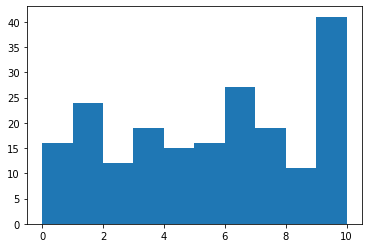

In [19]:
plt.hist(rho_values)
plt.show()

Comparing prior and posterior distribution

In [20]:
samples = np.zeros((200,4))
prior = np.zeros((200,4))
for i in tqdm.tqdm(range(200), position=0):    
    true_alpha = np.random.gamma(shape=a, scale=1/b, size=4)
    U = np.random.dirichlet(true_alpha, size=(n,))
    XY = np.column_stack([U[:,0] + U[:,1], U[:,0] + U[:,2]])
    data['xy'] = XY
    model_fit = model_v3.sample(data=data, iter_warmup=1000, show_progress=False, show_console=False, iter_sampling=1000, chains=1)
    alpha_hat = model_fit.stan_variables()['alpha'][-1,:]
    samples[i] = alpha_hat
    prior[i] = true_alpha

  0%|                                                   | 0/200 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  0%|▏                                          | 1/200 [00:01<03:35,  1.08s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  1%|▍                                          | 2/200 [00:02<03:19,  1.01s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  2%|▋                                          | 3/200 [00:03<03:29,  1.06s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
  2%|▊                                          | 4/200 [00:04<03:11,  1.03it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] d

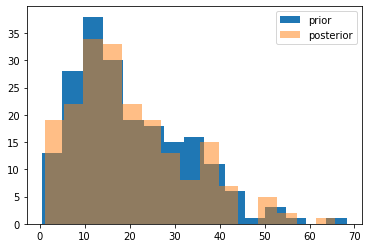

In [27]:
plt.hist(prior[:,0], bins=15, label='prior')
plt.hist(samples[:,0], bins=15, alpha=0.5, label='posterior')
plt.legend()
plt.show()

## Prior analysis model v2

In [22]:
data['prior_alpha'] = 1
model_fit1 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 2
model_fit2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 3
model_fit3 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 4
model_fit4 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 5
model_fit5 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


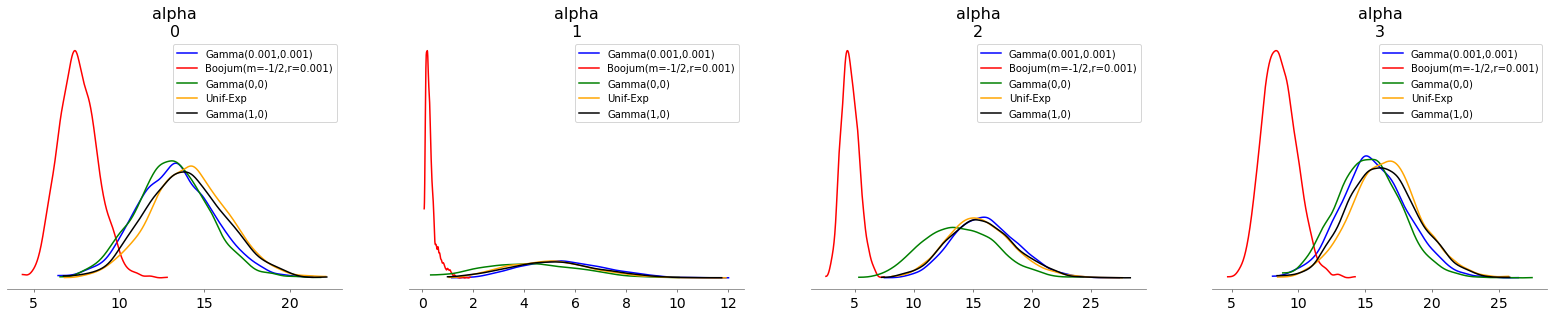

In [23]:
ax = az.plot_posterior(model_fit1, var_names=['alpha'], hdi_prob='hide', point_estimate=None, color='blue', label='Gamma(0.001,0.001)')
az.plot_posterior(model_fit2, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='red', label='Boojum(m=-1/2,r=0.001)')
az.plot_posterior(model_fit3, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='green', label='Gamma(0,0)')
az.plot_posterior(model_fit4, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='orange', label='Unif-Exp')
az.plot_posterior(model_fit5, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='black', label='Gamma(1,0)')
plt.show()

## Marginal gain of increasing sampling

In [24]:
true_alpha = np.array([2,7,3,1])

# Gamma hyperparameters
a = 0.001*np.array([1,1,1,1])
b = 0.001*np.array([1,1,1,1])

n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [25]:
n_values = [10, 30, 50, 100, 200, 500, 1000]
alpha_samples = np.zeros((len(n_values),4000,4))

for i, n in enumerate(n_values):
    
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    
    data['n'] = n
    data['xy'] = XY
    model_fit = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    
    alpha_samples[i,:,:] = model_fit.stan_variable('alpha')

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


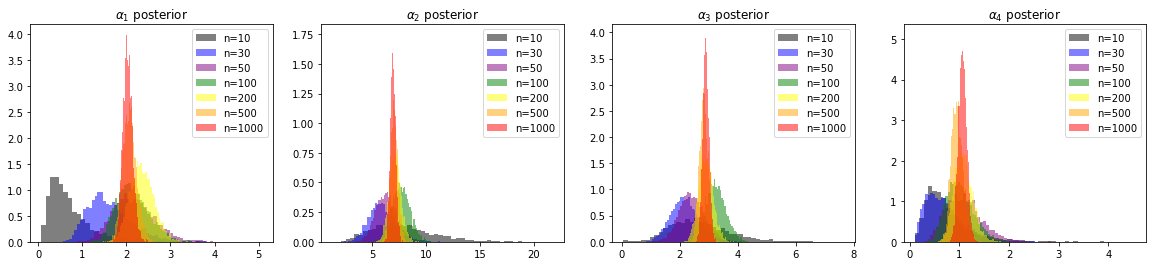

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
colors = ['black', 'blue', 'purple', 'green', 'yellow', 'orange', 'red']
for i in range(4):
    for k in range(7):
        ax[i].hist(alpha_samples[k,:,i], bins=50, color=colors[k], alpha=0.5, label='n={}'.format(n_values[k]), density=True)
    ax[i].set_title(r'$\alpha_{}$ posterior'.format(i+1))
    ax[i].legend()
plt.show()

## Analyzing the estimation

In [ ]:
def estimating_error(true_alpha, n, monte_carlo_simulation):
    
    U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
    X = U[:,:,0] + U[:,:,1]
    Y = U[:,:,0] + U[:,:,2]
    
    # Gamma hyperparameters
    a = 2*np.array([1,1,1,1])
    b = 0.1*np.array([1,1,1,1])

    # bojum prior
    m = -0.9
    r = b

    # uniform-exponential prior
    p = 0.5*np.ones(4)
    lambd = np.ones(4)
    c = 100*np.ones(4)

    data = {'n': n,
            'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
            'tolerance': 1e-8}
    
    mse = np.zeros(4)
    bias = np.zeros(4)
    coverage = np.zeros(4)
    mape = np.zeros(4)

    for i in tqdm.tqdm(range(monte_carlo_simulation)):
        XY = np.column_stack([X[:,i],Y[:,i]])
        data['xy'] = XY
        model_fit_v2 = model_v2.sample(data=data, chains=4, iter_warmup=1500, iter_sampling=1000, 
                                       show_progress=False, show_console=False)
        df = model_fit_v2.summary(percentiles=(2.5, 97.5))

        alpha_hat = df.iloc[1:5].Mean.values
        lb = df.iloc[1:5]['2.5%'].values
        ub = df.iloc[1:5]['97.5%'].values

        bias_new = alpha_hat - true_alpha
        mse_new = bias_new * bias_new
        mape_new = abs(bias_new)/true_alpha
        coverage_new = (lb < true_alpha)*(ub > true_alpha)

        bias = (bias * i + bias_new)/(i+1)
        mse = (mse * i + mse_new)/(i+1)
        mape = (mape * i + mape_new)/(i+1)
        coverage = (coverage * i + coverage_new)/(i+1)
    
    return bias, mse, mape, coverage

In [ ]:
n = 50
monte_carlo_simulation = 1000

true_alpha = np.array([1,1,1,1])
bias1, mse1, mape1, coverage1 = estimating_error(true_alpha, n, monte_carlo_simulation)

In [ ]:
true_alpha = np.array([2,7,3,1])
bias2, mse2, mape2, coverage2 = estimating_error(true_alpha, n, monte_carlo_simulation)

In [ ]:
true_alpha = np.array([0.7, 0.9, 2.0, 1.5])
bias3, mse3, mape3, coverage3 = estimating_error(true_alpha, n, monte_carlo_simulation)

In [ ]:
bias1, mse1, mape1, coverage1

In [64]:
n = 50
monte_carlo_simulation = 100
true_alpha = np.array([2,7,3,1])

U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

# Gamma hyperparameters
a = 1*np.array([1,1,1,1])
b = 1*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.9*np.ones(4)
lambd = np.ones(4)
c = 50*np.ones(4)

data = {'n': n,
        'prior_alpha': 4, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

mse = np.zeros(4)
bias = np.zeros(4)
coverage = np.zeros(4)
mape = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data['xy'] = XY
    model_fit = model_v3.sample(data=data, chains=4, iter_warmup=1000, iter_sampling=1000, 
                                   show_progress=False, show_console=False, adapt_delta=0.95)
    df = model_fit.summary(percentiles=(2.5, 50, 97.5))

    #alpha_hat = df.iloc[1:5].Mean.values
    alpha_hat = df.iloc[1:5]['50%'].values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values

    bias_new = alpha_hat - true_alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/true_alpha
    coverage_new = (lb < true_alpha)*(ub > true_alpha)

    bias = (bias * i + bias_new)/(i+1)
    mse = (mse * i + mse_new)/(i+1)
    mape = (mape * i + mape_new)/(i+1)
    coverage = (coverage * i + coverage_new)/(i+1)

  0%|                                                   | 0/100 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  1%|▍                                          | 1/100 [00:02<04:01,  2.44s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  2%|▊                                          | 2/100 [00:04<03:51,  2.36s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  3%|█▎                                         | 3/100 [00:06<03:43,  2.31s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  4%|█▋                                         | 4/100 [00:09<03:55,  2.46s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  5%|

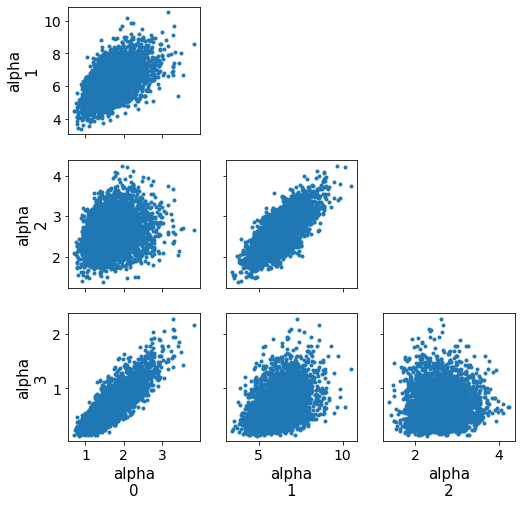

In [65]:
fig, ax = plt.subplots(3,3, figsize=(8,8))
az.plot_pair(model_fit, var_names=('alpha'), ax=ax)
plt.show()

In [66]:
bias, mse, mape, coverage

(array([-0.279 , -1.122 , -0.428 , -0.1309]),
 array([0.1775  , 1.7204  , 0.3228  , 0.093975]),
 array([0.1735    , 0.16457143, 0.15933333, 0.2469    ]),
 array([0.88, 0.77, 0.77, 0.9 ]))

## Jeffreys' prior

Calculating Jeffreys prior for $p(\alpha, u)$.

In [64]:
import sympy as sp

In [86]:
alpha1, alpha2, alpha3, alpha4, u, x, y = sp.symbols('alpha_1 alpha_2 alpha_3 alpha4 u x y')

f = (x-u)**(alpha2-1) * (y-u)**(alpha3-1) * (1-x-y+u)**(alpha4-1) / (1-u)**(alpha2+alpha3+alpha4-1)
f /= sp.gamma(alpha2)*sp.gamma(alpha3)*sp.gamma(alpha4)/sp.gamma(alpha2+alpha3+alpha4)
l = sp.expand_log(sp.log(f), force=True)

In [87]:
l_2 = sp.diff(l, alpha2)
l_3 = sp.diff(l, alpha3)
l_4 = sp.diff(l, alpha4)
l_u = sp.diff(l, u)

M = sp.Matrix([[l_2.diff(alpha2), l_2.diff(alpha3), l_2.diff(alpha4), l_2.diff(u)],
               [l_3.diff(alpha2), l_3.diff(alpha3), l_3.diff(alpha4), l_3.diff(u)],
               [l_4.diff(alpha2), l_4.diff(alpha3), l_4.diff(alpha4), l_4.diff(u)],
               [l_u.diff(alpha2), l_u.diff(alpha3), l_u.diff(alpha4), l_u.diff(u)]])

M

Matrix([
[-polygamma(1, alpha_2) + polygamma(1, alpha4 + alpha_2 + alpha_3),                          polygamma(1, alpha4 + alpha_2 + alpha_3),                         polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                 -1/(-u + x) + 1/(1 - u)],
[                         polygamma(1, alpha4 + alpha_2 + alpha_3), -polygamma(1, alpha_3) + polygamma(1, alpha4 + alpha_2 + alpha_3),                         polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                 -1/(-u + y) + 1/(1 - u)],
[                         polygamma(1, alpha4 + alpha_2 + alpha_3),                          polygamma(1, alpha4 + alpha_2 + alpha_3), -polygamma(1, alpha4) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                           1/(u -

$x-u = u_2 \sim Beta(\alpha_2, \alpha_1+\alpha_3+\alpha_4)$

$y-u = u_3 \sim Beta(\alpha_3, \alpha_1+\alpha_2+\alpha_4)$

$1-x-y+u = u_4 \sim Beta(\alpha_4, \alpha_1+\alpha_2+\alpha_3)$

I notice that if $X \sim Beta(\alpha, \beta)$, then $E[X^{-n}] = B(\alpha-n, \beta)/Beta(\alpha, \beta)$ if $\alpha > n$ and infinity otherwise.

In [99]:
M[3,3] = M[3,3].subs(1/(x-u)**2, sp.beta(alpha2-2, alpha1+alpha3+alpha4)/sp.beta(alpha2, alpha1+alpha3+alpha4))
M[3,3] = M[3,3].subs(1/(y-u)**2, sp.beta(alpha3-2, alpha1+alpha2+alpha4)/sp.beta(alpha3, alpha1+alpha2+alpha4))
v = M[3,3].subs(1/(1-x-y+u)**2, sp.beta(alpha4-2, alpha1+alpha2+alpha3)/sp.beta(alpha4, alpha1+alpha2+alpha3))
M = M.subs(1/(x-u), sp.beta(alpha2-1, alpha1+alpha3+alpha4)/sp.beta(alpha2, alpha1+alpha3+alpha4))
M = M.subs(1/(y-u), sp.beta(alpha3-1, alpha1+alpha2+alpha4)/sp.beta(alpha3, alpha1+alpha2+alpha4))
M = M.subs(1/(1-x-y+u), sp.beta(alpha4-1, alpha1+alpha2+alpha3)/sp.beta(alpha4, alpha1+alpha2+alpha3))
M[3,3] = v
M

Matrix([
[                                   -polygamma(1, alpha_2) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                             polygamma(1, alpha4 + alpha_2 + alpha_3),                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                                                                                                                                                                 -beta(alpha_2 - 1, alpha4 + alpha_1 + alpha_3)/beta(alpha_2, alpha4 + alpha_1 + alpha_3) + 1/(1 - u)],
[                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                                    -polygamma(1, alpha_3) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                     

Note que a priori de Jeffreys só está definida se $\alpha_i > 2, i=2,3,4$, isto é, a densidade tem valor inifinito se $\alpha_2 \le 2$, por exemplo.

## ABC Algorithm

We first define the models: gamma and bivariate beta

In [73]:
from abcpy.probabilisticmodels import ProbabilisticModel, Continuous, InputConnector
from abcpy.statistics import Identity, LinearTransformation
from abcpy.distances import Euclidean, Distance
from abcpy.perturbationkernel import DefaultKernel
from abcpy.backends import BackendDummy as Backend
from abcpy.inferences import SMCABC, PMCABC

In [46]:
class Gamma(ProbabilisticModel, Continuous):
    
    def __init__(self, parameters, name='Gamma'):
        # We expect input of type parameters = [alpha, beta]
        if not isinstance(parameters, list):
            raise TypeError('Input of Gamma model is of type list')
        if len(parameters) != 2:
            raise RuntimeError('Input list must be of length 2, containing [alpha, beta].')

        input_connector = InputConnector.from_list(parameters)
        super().__init__(input_connector, name)
        
    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != 2:
            raise ValueError('Number of parameters of Gamma model must be 2.')

        # Check whether input is from correct domain
        alpha = input_values[0]
        beta = input_values[1]
        if alpha <= 0 or beta <= 0:
            return False

        return True
    
    def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
        # Extract the input parameters
        alpha = input_values[0]
        beta = input_values[1]

        # Do the actual forward simulation
        vector_of_k_samples = rng.gamma(shape=alpha, scale=1/beta, size=k)

        # Format the output to obey API
        result = [np.array([x]) for x in vector_of_k_samples]
        return result
    
    def _check_output(self, values):
        if values <= 0:
            return False
        return True
    
    def get_output_dimension(self):
        return 1

    def pdf(self, input_values, x):
        alpha = input_values[0]
        beta = input_values[1]
        pdf = stats.gamma(a=alpha, scale=1/beta).pdf(x)
        return pdf
    
class BivariateBeta(ProbabilisticModel, Continuous):
    
    def __init__(self, parameters, name='BivariateBeta'):
        # We expect input of type parameters = [alpha1, ..., alpha4]
        if not isinstance(parameters, list):
            raise TypeError('Input of BIvariate Beta model is of type list')
        if len(parameters) != 4:
            raise RuntimeError('Input list must be of length 1, containing [alpha].')
        input_connector = InputConnector.from_list(parameters)
        
        super().__init__(input_connector, name)
        
    def _check_input(self, input_values):
        # Check whether input has correct type or format
        if len(input_values) != 4:
            raise ValueError('Number of parameters of Bivariate Beta model must be 4.')

        # Check whether input is from correct domain
        alpha = np.array(input_values)
        if sum(alpha < 0) != 0:
            return False

        return True
    
    def forward_simulate(self, input_values, k, rng=np.random.RandomState()):
        # Extract the input parameters
        alpha = input_values

        # Do the actual forward simulation
        U = rng.dirichlet(alpha, size=k)
        vector_of_k_samples = np.column_stack([U[:,0]+U[:,1], U[:,0]+U[:,2]])

        # Format the output to obey API
        result = [vector_of_k_samples[i,:] for i in range(k)]
        return result
    
    def _check_output(self, values):
        if sum(values < 0) + sum(values > 1) > 0:
            return False
        return True
    
    def get_output_dimension(self):
        return 2

    def pdf(self, input_values, x):
        alpha = input_values
        distribution = bb_class(alpha)
        return distribution.pdf(x[0], x[1])
    
class Absolute_sufficient_statistics(Distance):

    def __init__(self, statistics_calc):
        super().__init__(statistics_calc)
        self.s1_mean = None

    def distance(self, d1, d2):
        s1, s2 = self._calculate_summary_stat(d1, d2)
        if self.s1_mean is None:
            self.s1_mean = s1.mean(axis=0)
        return np.sum(abs(self.s1_mean - s2.mean(axis=0)))
    
    def dist_max(self):
        return 5

We can now work with these models

In [101]:
# Defining priors
alpha1 = Gamma([[2], [.1]], name='alpha1')
alpha2 = Gamma([[2], [.1]], name='alpha2')
alpha3 = Gamma([[2], [.1]], name='alpha3')
alpha4 = Gamma([[2], [.1]], name='alpha4')

# Defining the model
xy = BivariateBeta([alpha1, alpha2, alpha3, alpha4], name='xy')

# Defining Statistics
statistics_calculator = Identity(degree=2, cross=True)

# Defining Distance
distance_calculator = Euclidean(statistics_calculator)

# Defining Kernel
kernel = DefaultKernel([alpha1, alpha2, alpha3, alpha4])

# Defining Backend: the dummy backend does not parallelize the code!
backend = Backend()

# Defining sampling scheme
sampler = PMCABC([xy], [distance_calculator], backend, kernel, seed=1)

Now we can work with the sampler. First, generate some data.

In [102]:
U = np.random.dirichlet([1,1,1,1], size=50)
X = U[:,0]+U[:,1]
Y = U[:,0]+U[:,2]
XY = list(np.column_stack([X,Y]))

In [103]:
%%time
journal = sampler.sample([XY], steps=3, n_samples=250, epsilon_init=[0.5])

KeyboardInterrupt: 

In [104]:
par = journal.get_parameters()
# post analysis
print(journal.posterior_mean())

{'alpha1': 20.60332059558052, 'alpha2': 21.980951628204792, 'alpha3': 18.247054482087105, 'alpha4': 18.355770830519784}


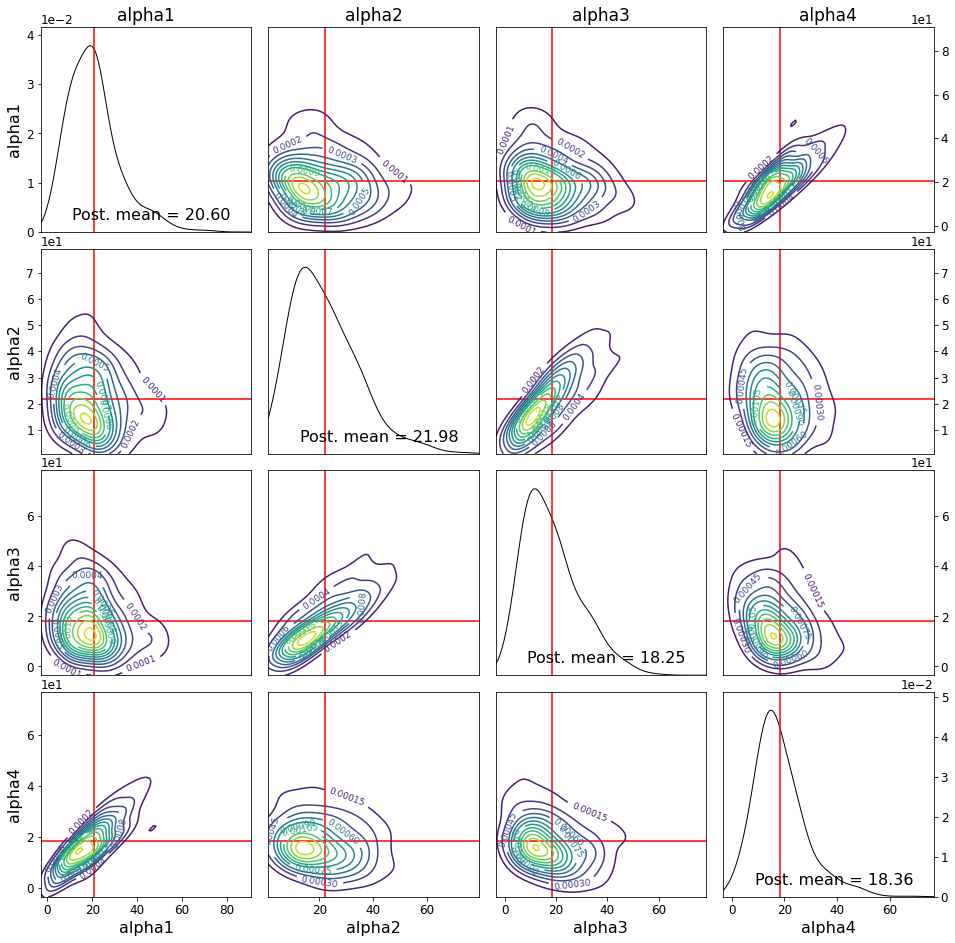

In [105]:
journal.plot_posterior_distr()
plt.show()

In [98]:
U = np.random.dirichlet(list(journal.posterior_mean().values()), size=50)
X = U[:,0]+U[:,1]
Y = U[:,0]+U[:,2]
XY2 = list(np.column_stack([X,Y]))

In [92]:
statistics_calculator.statistics(XY).mean(axis=0)

array([0.5234177 , 0.46710019, 0.33206864, 0.264394  , 0.2579746 ])

In [99]:
statistics_calculator.statistics(XY2).mean(axis=0)

array([0.54357259, 0.47938602, 0.29828656, 0.23389661, 0.26130551])